# Importing libraries

In [1]:
# Install libraries
'''
#%pip install pydub
%pip install librosa
%pip install -q evaluate transformers==4.28.1
%pip install -U -q datasets
%pip install -q torchaudio==0.12
#%add-apt-repository -y ppa:savoury1/ffmpeg4 
#%apt-get -qq install -y ffmpeg
%pip install -q mlflow
%pip install soundfile
'''

'\n#%pip install pydub\n%pip install librosa\n%pip install -q evaluate transformers==4.28.1\n%pip install -U -q datasets\n%pip install -q torchaudio==0.12\n#%add-apt-repository -y ppa:savoury1/ffmpeg4 \n#%apt-get -qq install -y ffmpeg\n%pip install -q mlflow\n%pip install soundfile\n'

In [25]:
# Import libraries
# TODO: Check if we use all of these later, otherwise remove
import pandas as pd
import gc
import re
import numpy as np

#import warnings 
#warnings.filterwarnings("ignore")

from tqdm import tqdm
tqdm.pandas()
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
import torch
import datasets
import transformers
print(transformers.__version__)

import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import pylab

import librosa
import librosa.display

from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import librosa
from datasets import Dataset
from collections import Counter
from pathlib import Path
import torchaudio
from torch import optim
import matplotlib.pyplot as plt

4.28.1


# Adding all files to dataframe df

In [3]:
# Read csv files for train and test data
df_list = []
for loc in ['Train', 'Test']:
    df_tmp = pd.read_csv(f"archive\Metadata_{loc}.csv")
    df_list.append(df_tmp)

df = pd.concat(df_list, axis=0)

df['Class'] = df['Class'].replace({"Sound_Guiatr": "Sound_Guitar"})

# remove violin label as it is contaminated by Drums
df = df[df['Class']!="Sound_Violin"]

print(df.shape)
df.sample(5).T

(1989, 2)


,736,2604,1106,104,663
FileName,boje-3-87816.wav,ROOM_room8_MUS_pachelbel_DEV_lg.wav,WaveDrum02_39KD (75).wav,AR_NH_VII.wav,slow_latin_3_100BPM.wav
Class,Sound_Drum,Sound_Piano,Sound_Drum,Sound_Guitar,Sound_Guitar


In [4]:
# Count the files of each class.
df['Class'].value_counts()

Class
Sound_Guitar    720
Sound_Drum      720
Sound_Piano     549
Name: count, dtype: int64

# Setting the labels

In [5]:
# TODO: These values are unused at the moment
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 240000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)

# Change labels to numbers. 0 = guitar, 1 = drum, 2 = piano
labels = ['Sound_Guitar', 'Sound_Drum', 'Sound_Piano']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'Sound_Guitar', 1: 'Sound_Drum', 2: 'Sound_Piano'} 

 {'Sound_Guitar': 0, 'Sound_Drum': 1, 'Sound_Piano': 2}


# Add file paths to dataFrame

In [6]:
# Go through the data and add the filenames and filepaths to the sound files.
def load_data():
    file_list = []
    sample_list = []
    for file in Path('archive/').glob('*_submission\*_submission\*.wav'):
        sample_name = file.stem + '.wav' #re.match(r"(\d+)", file.stem).group(0)
        file_list.append(file)
        sample_list.append(str(sample_name))
    dd = pd.DataFrame()
    dd['file'] = file_list
    dd['FileName'] = sample_list
    return dd

In [7]:
dd = load_data()
dd = dd.set_index('FileName').join(df.set_index('FileName'), how='inner')
dd = dd[dd['Class'].isin(labels)]
dd['label'] = dd['Class'].apply(lambda x: label2id[x])
selected_cols = ['file', 'label', 'Class']
dd = dd[selected_cols]
dd.sample(5).T

FileName,AR_B_fret_0-20.wav,ROOM_room4_MUS_mozart_DEV_iphone.wav,drum-beat-02-36276.wav,ROOM_room6_MUS_scale_DEV_redmi.wav,ROOM_room6_MUS_mozart_DEV_ipad.wav
file,archive\Train_submission\Train_submission\AR_B...,archive\Train_submission\Train_submission\ROOM...,archive\Train_submission\Train_submission\drum...,archive\Train_submission\Train_submission\ROOM...,archive\Train_submission\Train_submission\ROOM...
label,0,2,1,2,2
Class,Sound_Guitar,Sound_Piano,Sound_Drum,Sound_Piano,Sound_Piano


In [8]:
dd = dd.reset_index(drop=True)
dd.head()

,file,label,Class
0,archive\Train_submission\Train_submission\0295...,2,Sound_Piano
1,archive\Train_submission\Train_submission\0355...,2,Sound_Piano
2,archive\Train_submission\Train_submission\04-4...,1,Sound_Drum
3,archive\Train_submission\Train_submission\0465...,1,Sound_Drum
4,archive\Train_submission\Train_submission\0543...,1,Sound_Drum


In [9]:
#d_save = dd
#dd = dd.dropna(subset=['audio'])
#dd.shape

In [10]:
df.head()

,FileName,Class
0,1-E1-Major 00.wav,Sound_Guitar
1,1-E1-Major 01.wav,Sound_Guitar
2,1-E1-Major 02.wav,Sound_Guitar
3,1-E1-Major 03.wav,Sound_Guitar
4,1-E1-Major 04.wav,Sound_Guitar


In [11]:
# Borrowed from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)
    
#https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")


In [108]:
def open(audio_file):
    # TODO: Later, the load function can also be used to set the sampling rate and the time of the clip to be used
    sig, sr = librosa.load(audio_file)
    return (sig, sr)

def display_mel(aud, n_mels=64, n_fft=1024, hop_len=None):
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    return

def save_mel(aud, filename, n_mels=64, n_fft=1024, hop_len=None):
    plt.axis('off') # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    plt.savefig(filename)
    return

'''
def display_mel(aud, n_mels=64, n_fft=1024, hop_len=None):
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    return

def save_mel(aud, filename, n_mels=64, n_fft=1024, hop_len=None):
    pylab.clf()
    pylab.axis('off') # no axis
    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
    S = librosa.feature.melspectrogram(y=sig, sr=fs)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.show()
    pylab.savefig(filename)
    pylab.clf()
    plt.show()
    #plt.close()
    #plt.open()
    return'''

"\ndef display_mel(aud, n_mels=64, n_fft=1024, hop_len=None):\n    pylab.axis('off') # no axis\n    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge\n    S = librosa.feature.melspectrogram(y=sig, sr=fs)\n    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))\n    plt.show()\n    return\n\ndef save_mel(aud, filename, n_mels=64, n_fft=1024, hop_len=None):\n    pylab.clf()\n    pylab.axis('off') # no axis\n    pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge\n    S = librosa.feature.melspectrogram(y=sig, sr=fs)\n    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))\n    plt.show()\n    pylab.savefig(filename)\n    pylab.clf()\n    plt.show()\n    #plt.close()\n    #plt.open()\n    return"

# Display data

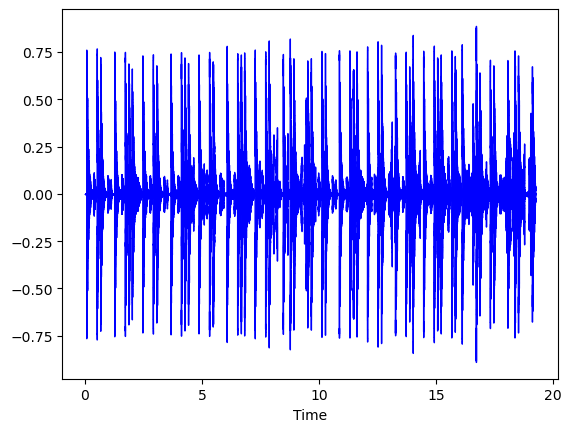

In [61]:
y,sr=librosa.load('archive/Test_submission/Test_submission/100bpm-808-like-drum-loop-74838.wav') #load the file
librosa.display.waveshow(y,sr=sr, axis='time', color='blue')

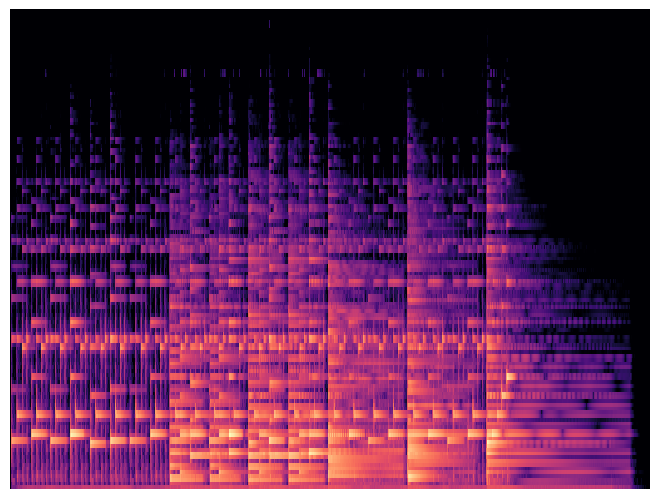

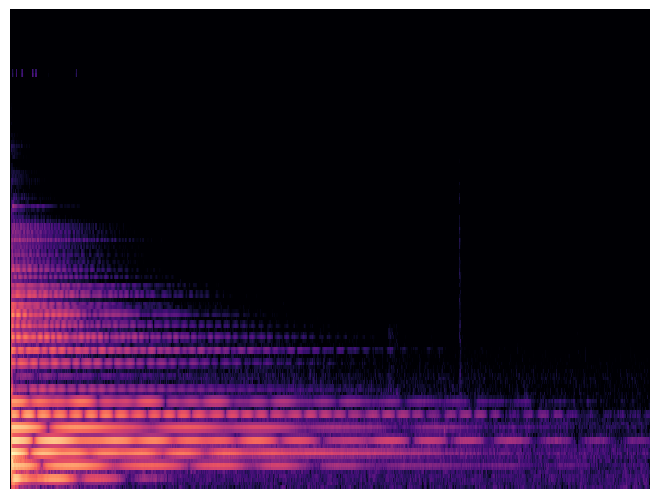

In [104]:
sig, fs = open(dd['file'][0])
display_mel((sig,fs))

sig, fs = open(dd['file'][1])
display_mel((sig,fs))

archive\Train_submission\Train_submission\029500_morning-rain-piano-65875.wav


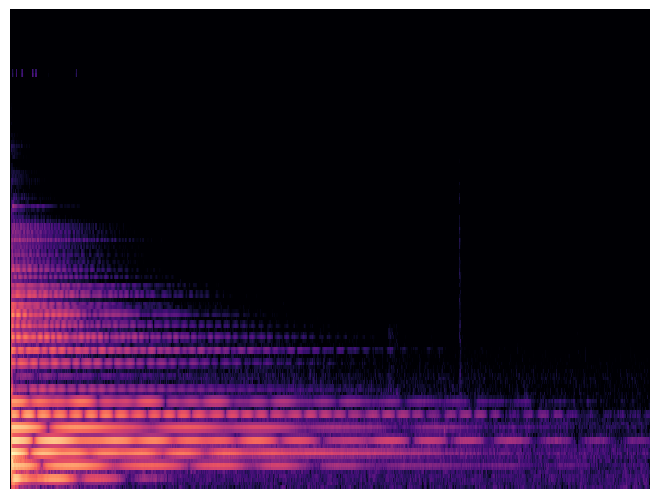

archive\Train_submission\Train_submission\035568_upright-piano-71570.wav


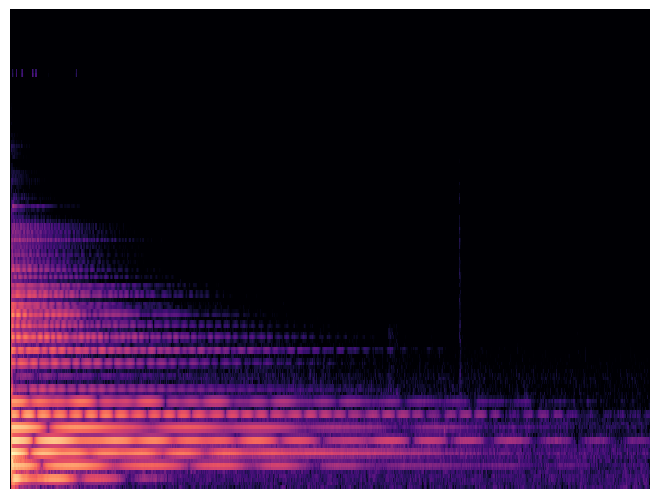

archive\Train_submission\Train_submission\04-47367.wav


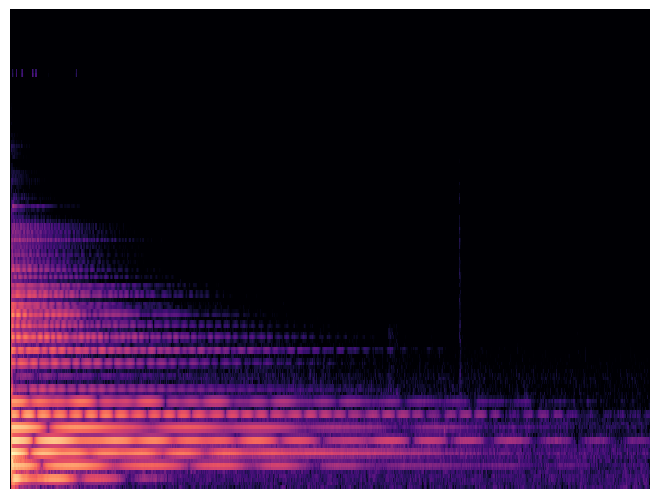

archive\Train_submission\Train_submission\046578_tribal-drum-rhythms-03wav-68096.wav


In [111]:
import os
if not os.path.exists('test_folder'):
   os.makedirs('test_folder')

plt.show()
#plt.close()
for i, file in enumerate(dd['file']):
    a, b = open(file)
    print(file)
    if i == 3:
        break
    save_mel((a,b), "test_folder/img{}".format(i))
    plt.close()

In [ ]:
dd.shape, dd['label'].value_counts()

In [ ]:
#%%time
#dd = dd.drop(['file'], axis=1)
type(dd)

In [26]:
dd.sample(5).T

,893,1232,1101,336,1169
file,archive\Train_submission\Train_submission\ROOM...,archive\Train_submission\Train_submission\Wave...,archive\Train_submission\Train_submission\Real...,archive\Train_submission\Train_submission\G53-...,archive\Train_submission\Train_submission\Wave...
label,2,1,1,0,1
Class,Sound_Piano,Sound_Drum,Sound_Drum,Sound_Guitar,Sound_Drum


In [ ]:
dd = Dataset.from_pandas(dd)

In [ ]:
Counter(dd['label']).items()

# Network stuff

In [ ]:

class FirstCnn(nn.Module):
    def __init__(self, img_size):
        super().__init__()
        self.img_size = img_size

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=0)
        
        # Calculate the output size after two convolutional layers
        self.conv_output_size = self.calculate_conv_output_size()
        
        self.fc1 = nn.Linear(self.conv_output_size, 1)  # Output size is 1 for binary classification (dog or not)
        
    def calculate_conv_output_size(self):
        # Define a dummy input tensor to calculate the output size after convolutions
        dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)
        dummy_output = self.forward_conv(dummy_input)
        return dummy_output.view(1, -1).size(1)

    def forward_conv(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

    def forward(self, x):
        x = self.forward_conv(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        x = torch.sigmoid(self.fc1(x))  # Sigmoid activation for binary classification
        return x.squeeze()

In [ ]:
def training_loop_1(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch_1(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate_1(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch_1(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate_1(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate_1(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)


def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.long())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())
        hard_preds = output_to_label(z)
        hard_preds = hard_preds.argmax(dim=1)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.long())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            hard_preds = hard_preds.argmax(dim=1)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)

In [ ]:

transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])
train_dataloader = DataLoader(DogsCatsData(small_train_path, transform), batch_size=64, shuffle=True)
valid_dataloader = DataLoader(DogsCatsData(small_val_path, transform), batch_size=64, shuffle=True)

In [ ]:

loss_fn = nn.CrossEntropyLoss()
first_model = FirstCnn(32)
optimizer = optim.Adam(first_model.parameters(), lr = 0.005)
first_model_32, train_losses_32, train_accs_32, val_losses_32, val_accs_32 = training_loop_1(first_model, optimizer, loss_fn, train_dataloader, valid_dataloader,10,1)

# Everything after this point is unused at the moment

# Load facebook/wav2vec2-base-960h model

In [ ]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    #top_db = 80

    librosa.feature.melspectrogram(y=sig, sr=sr)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(sig, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()
    
    plt.savefig("test.png")
    #spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    #spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return #(spec)

In [ ]:
# Inspired by https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
# Not used at the moment
'''
def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
'''

In [ ]:
#def get_transform_audio(file):
#    audio,rate = torchaudio.load(str(file))
#    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
#    audio = transform(audio).squeeze(0).numpy()
#    audio = audio[:MAX_LENGTH] # truncate to first part of audio to save RAM
    # return audio only if it is full length audio
#    if audio.shape[0]==MAX_LENGTH:
#        return audio
#dd['audio'] = dd['file'].progress_apply(get_transform_audio)

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification

model_str = "facebook/wav2vec2-base-960h" 
feature_extractor = AutoFeatureExtractor.from_pretrained(model_str)
model = AutoModelForAudioClassification.from_pretrained(model_str,num_labels=len(labels))
model.config.id2label = id2label
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

In [ ]:
def preprocess_function(batch):    
    inputs = feature_extractor(batch['audio'], sampling_rate=RATE_HZ, max_length=MAX_LENGTH, truncation=True)
    inputs['input_values'] = inputs['input_values'][0]
    return inputs

dd['test'] = dd['test'].map(preprocess_function, remove_columns="audio", batched=False)
dd['train'] = dd['train'].map(preprocess_function, remove_columns="audio", batched=False)

In [ ]:
gc.collect()

# Train and evaluate model

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

from sklearn.metrics import roc_auc_score
def compute_metrics(eval_pred):
    # Compute the ROC AUC score
    predictions = eval_pred.predictions
    predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    roc_auc = roc_auc_score(label_ids, predictions, average='macro', multi_class='ovr') # one-vs-rest ROC AUC score
    
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    return {
        "roc_auc": roc_auc,
        "accuracy": acc_score
    }

In [ ]:
from transformers import TrainingArguments, Trainer
batch_size=1
warmup_steps=50
weight_decay=0.02
num_train_epochs=2
model_name = "musical_instrument_detection"
training_args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=5e-6, # 1e-6
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    evaluation_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    eval_steps=1,
    save_strategy='epoch',
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dd["train"],
    eval_dataset=dd["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate()

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model()

In [ ]:
from transformers import pipeline

pipe=pipeline('audio-classification',model=model_name,device=0)

In [ ]:
# Drum example
audio,rate=torchaudio.load('/kaggle/input/musical-instruments-sound-dataset/Train_submission/Train_submission/DRUM_SOUND (48).wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)[:MAX_LENGTH]
# make a classification pipeline
pipe(audio)

In [ ]:
# Guitar example
audio,rate=torchaudio.load('/kaggle/input/musical-instruments-sound-dataset/Test_submission/Test_submission/rock_6_100BPM.wav')
transform=torchaudio.transforms.Resample(rate,RATE_HZ)
audio=transform(audio).numpy().reshape(-1)[:MAX_LENGTH]
print(audio.shape)
# make a classification pipeline
pipe(audio)

In [ ]:
from IPython.display import Audio
Audio(audio,rate=RATE_HZ)

# Send model to Huggingface

In [ ]:
# finally, save the model to Huggingface
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"dima806/{model_name}"
try:
    api.create_repo(repo_id)
except:
    print(f"Repo {repo_id} already exists")

In [ ]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)